Found 1 device(s)
Setting up data collection for: <ADQ S/N: SPD-10702>
Starting data acquisition
0

	Record number: 0
	N counts clipping: 0
[216 183 250 ... 133 200 150]
1
2

	Record number: 2
	N counts clipping: 0
[166 183 216 ... 116 200 166]
3
4

	Record number: 4
	N counts clipping: 0
[200 150 200 ... 200 150 200]
5
6

	Record number: 6
	N counts clipping: 0
[183 133 200 ... 166 200 183]
7
8

	Record number: 8
	N counts clipping: 0
[250 233 216 ... 216 233 166]
9
10

	Record number: 10
	N counts clipping: 0
[233 216 216 ... 216 183 250]
11
12

	Record number: 12
	N counts clipping: 0
[216 200 183 ... 200 250 150]
13
14

	Record number: 14
	N counts clipping: 0
[216 250 183 ... 183 200 250]
15
16

	Record number: 16
	N counts clipping: 0
[216 150 200 ... 200 233 200]
17
18

	Record number: 18
	N counts clipping: 0
[216 200 216 ... 183 200 183]
19
20

	Record number: 20
	N counts clipping: 0
[233 166 216 ... 183 166 250]
21
22

	Record number: 22
	N counts clipping: 0
[183 233 200 ..

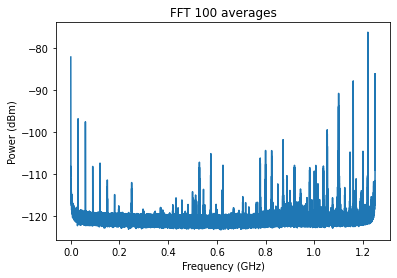

Stopping data acquisition


In [2]:
#!/usr/bin/env python3
# Copyright 2022 Teledyne Signal Processing Devices Sweden AB
"""
 Example illustrating the data acquisition for a ADQ3 series digitizer. The
 example will list the available devices and acquire data from the first
 device.
"""

import pyadq
from typing import List
import numpy as np
import time

import matplotlib.pyplot as plt

# Record length in samples
RECORD_LENGTH = int(2**21)
# Number of records to collect per channel
NOF_RECORDS = 100
# Periodic event generator frequency in Hz
PERIODIC_EVENT_GENERATOR_FREQUENCY = 10e3

SIZEOF_INT16 = 2
NOF_RECORDS_PER_BUFFER = 1

nof_chan = 1


# Create the control unit
acu: pyadq.ADQControlUnit = pyadq.ADQControlUnit()

# Enable trace logging
acu.ADQControlUnit_EnableErrorTrace(pyadq.LOG_LEVEL_INFO, ".")

# List the available devices
device_list: List[pyadq.ADQInfoListEntry] = acu.ListDevices()

print(f"Found {len(device_list)} device(s)")

# Ensure that at least one device is available
assert device_list

# Set up the first available device
device_to_open = 0
dev: pyadq.ADQ = acu.SetupDevice(device_to_open)

print(f"Setting up data collection for: {dev}")

# Initialize the parameters with default values
parameters: pyadq.ADQParameters = dev.InitializeParameters(pyadq.ADQ_PARAMETER_ID_TOP)

parameters.constant.clock_system.clock_generator = pyadq.ADQ_CLOCK_GENERATOR_EXTERNAL_CLOCK
# Set up data collection for all channels
for acq_param in parameters.acquisition.channel[0 : nof_chan]:
    acq_param.record_length = RECORD_LENGTH
    acq_param.nof_records = pyadq.ADQ_INFINITE_NOF_RECORDS
    acq_param.trigger_edge = pyadq.ADQ_EDGE_RISING
    acq_param.trigger_source = pyadq.ADQ_EVENT_SOURCE_PERIODIC

# Configure data transfer parameters for all channels
for transfer_param in parameters.transfer.channel[0 : parameters.constant.nof_channels]:
    transfer_param.record_size = SIZEOF_INT16 * RECORD_LENGTH
    transfer_param.record_length_infinite_enabled = 0
    transfer_param.record_buffer_size = (
        NOF_RECORDS_PER_BUFFER * SIZEOF_INT16 * RECORD_LENGTH
    )
    # Enable metadata (record headers)
    transfer_param.metadata_enabled = 1
    transfer_param.metadata_buffer_size = (
        NOF_RECORDS_PER_BUFFER * pyadq.SIZEOF_ADQ_GEN4_HEADER
    )
    transfer_param.nof_buffers = pyadq.ADQ_MAX_NOF_BUFFERS

# Configure the periodic event generator
parameters.event_source.periodic.frequency = PERIODIC_EVENT_GENERATOR_FREQUENCY

# Set parameters
dev.SetParameters(parameters)

# Start the data acquisition
print("Starting data acquisition")
result = dev.ADQ_StartDataAcquisition()
if result != pyadq.ADQ_EOK:
    raise Exception(
        f"ADQ_StartDataAcquisition failed with error code {result}. See log file."
    )

record_count = 0
records_to_collect = NOF_RECORDS * parameters.constant.nof_channels

avg = np.zeros(RECORD_LENGTH//2)

try:
    while record_count < records_to_collect:
        # Wait for a record buffer on any channel with 1000 ms timeout
        record_buffer = dev.WaitForRecordBuffer(pyadq.ADQ_ANY_CHANNEL, 1000)
        print(record_count)
        if record_count%2 == 0:
            
            # Print some header information
            print(
                #f"S/N: {record_buffer.header.serial_number}, "
                #f"channel {record_buffer.header.channel}"
            )
            print(f"\tRecord number: {record_buffer.header.record_number}")
            #print(f"\tRecord length: {record_buffer.header.record_length}")
            #print(f"\tData: {record_buffer.data}")
            print(f"\tN counts clipping: {(record_buffer.data==2**15).sum() + (record_buffer.data==-2**15).sum()}")

            fft = np.abs(np.fft.fft(record_buffer.data)[0:(RECORD_LENGTH//2)])
            avg += fft
            print(record_buffer.data)
            if 0:
                plt.figure()
                plt.title('time')
                plt.plot(record_buffer.data)
                plt.show()

                fft_mW = fft**2 * 2**-34*2/(50*RECORD_LENGTH**2)*1000
                plt.figure()
                plt.plot(np.linspace(0,1.25,RECORD_LENGTH//2)[1:],10*np.log10(fft_mW[1:]))
                plt.xlabel('Frequency (GHz)')
                plt.ylabel('Power (dBm)')
                plt.show()
                plt.close('all')

                


        record_count += 1

        

except Exception as e:
    dev.ADQ_StopDataAcquisition()
    raise e

if 0: #time domain ADC counts
    plt.figure()
    plt.title('Time Domain')
    plt.plot(record_buffer.data)
    plt.xlabel('Samples')
    plt.ylabel('Adc counts')
    plt.show()

if 0: #time domain mV
    plt.figure()
    plt.title('Time Domain')
    plt.plot(record_buffer.data/2**16 * 500)
    plt.xlabel('Samples')
    plt.ylabel('miliVolts')
    plt.show()



avg/=(record_count/2)
plt.figure()
plt.title('FFT %i averages' %(record_count//2))
avg = avg**2 * 2**-34*2/(50*RECORD_LENGTH**2)*1000
plt.plot(np.linspace(0,1.25,RECORD_LENGTH//2)[1:],10*np.log10(avg[1:]))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dBm)')
plt.show()

# Stop the data acquisition
print("Stopping data acquisition")
result = dev.ADQ_StopDataAcquisition()
if result not in [pyadq.ADQ_EOK, pyadq.ADQ_EINTERRUPTED]:
    raise Exception(
        f"ADQ_StartDataAcquisition failed with error code {result}. See log file."
    )


In [3]:
#analysis

sys.path.insert(0, '../../../drlib')
import drlib as dr
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2Freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

sampleRate = 2.5e9 #GHz
freqs = np.linspace(0, sampleRate/2, RECORD_LENGTH//2 )


#filter and plot with 5sigma limit. Note these are not gain corrected!!!
nSigma = 5
order = 1
fc_numBins = 100

specFiltered = dr.filterSpec(avg, fc_numBins=fc_numBins, order=order)
window = 1000

rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)
filter_fc           = 30 * window
filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
rollMadLim      = diffFilterMadPadArr * nSigma * 1.48


KeyboardInterrupt: 

6
[7.20000954e+07 3.59622583e+08 5.87759578e+08 6.92886775e+08
 9.89750376e+08 1.01195551e+09]


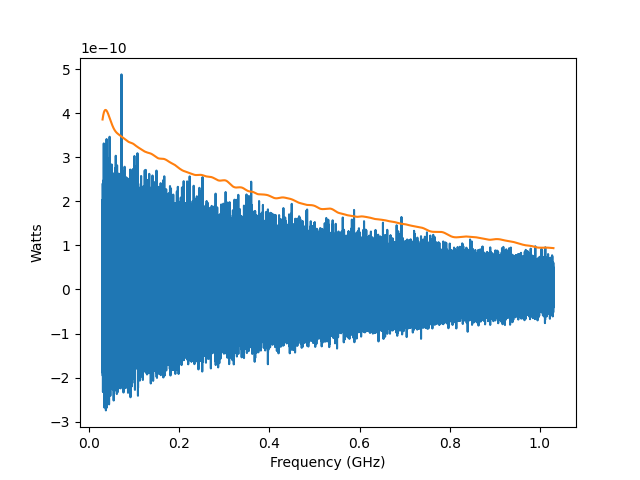

In [109]:
pltFreqStart = 30e6
pltFreqStop = 1.03e9
pltIdxStart = freq2Idx(pltFreqStart, freqs)
pltIdxStop = freq2Idx(pltFreqStop, freqs)

plt.close('all')
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e9, specFiltered[pltIdxStart:pltIdxStop])
plt.plot(freqs[pltIdxStart:pltIdxStop]/1e9,(rollMadLim)[pltIdxStart:pltIdxStop])
plt.xlabel('Frequency (GHz)')
plt.ylabel('Watts')

spurList_idx = ((specFiltered > rollMadLim))
print(spurList_idx[pltIdxStart:pltIdxStop].sum())
print((freqs[pltIdxStart:pltIdxStop][spurList_idx[pltIdxStart:pltIdxStop]]))